In [9]:
from sklearn.datasets import fetch_openml
import torch
import numpy as np

mnist = fetch_openml('mnist_784')

# GPU 사용지정
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

# 7만개 중 앞 6만개 데이터 train 가정
# 각 이미지를 1 * 28 * 28 차원으로 변환
X_train = torch.tensor(np.array(mnist.data)).float().reshape(-1,1,28,28)[:60000].to(device)
y_train = torch.tensor(np.array(list(map(np.int_,mnist.target))))[:60000].to(device)

# 7만개 중 뒤 1만개 데이터 test 가정
# 각 이미지를 1 * 28 * 28 차원으로 변환
X_test = torch.tensor(np.array(mnist.data)).float().reshape(-1,1,28,28)[60000:].to(device)
y_test = torch.tensor(np.array(list(map(np.int_,mnist.target))))[60000:].to(device)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [12]:
# Data Augmentation
'''
랜덤으로 10*10 픽셀 부위를 골라 회색으로 마킹한 뒤
왼쪽으로 90도 회전하는 Data Augmentation 구현
'''
def cutout_and_rotate(image):
    image = image.clone().detach() # 얕은 복사 문제 주의(원본 보존)
    x_start = np.random.randint(20) # cut out 시작할때 x축 위치 0~19중 1개
    y_start = np.random.randint(20) # cut out 시작할때 y축 위치 0-19중 1개

    image[..., x_start:x_start+9, y_start:y_start+9] = 255/2 # 해당 부분 회색 마스킹
    return torch.rot90(image,1,[-2,-1]) # 마지막 두 axis 기준 90도 회전

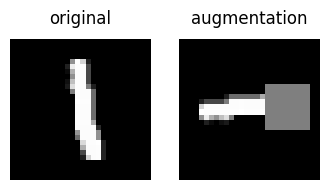

In [15]:
# Data Augmentation 여부 확인
import matplotlib.pyplot as plt
from matplotlib.pyplot import style

# 흰색 배경 및 크기 지정
style.use('default')
figure = plt.figure()
figure.set_size_inches(4,2)

# 흑백으로 출력하기 위한 스타일 설정
style.use('grayscale')

# 1*2 사이즈의 격자 설정
axes = []
for i in range(1,3):
    axes.append(figure.add_subplot(1,2,i))

# 첫 이미지에 대한 원본 이미지 및 augmentation 수행된 이미지 시각화
img_example = X_train[6].clone().detach().cpu()
original = np.array(img_example).reshape(-1,28).astype(int)
aug_img = np.array(cutout_and_rotate(img_example)).reshape(-1,28).astype(int)

axes[0].matshow(original)
axes[1].matshow(aug_img)

# 제목 설정 및 눈금 제거
axes[0].set_axis_off()
axes[0].set_title('original')
axes[1].set_axis_off()
axes[1].set_title('augmentation')
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    '''
    Convolution layer가 2개 존재하는 CNN 구조 정의
    각 Layer를 거칠 때 마다 변화하는 shape는 주석에 포함
    각 이미지의 output 벡터 차원은 100차원으로 가정
    '''
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 5, stride = 1)
        self.fc = nn.Linear(4*4*20,100)

    def forward(self,x):
        x = F.relu(self.conv1(x)) # (batch,1,28,28) -> (batch, 10, 24, 24)
        x = F.max_pool2d(x,kernel_size = 2, stride = 2) # (batch, 10, 24, 24) -> (batch, 10, 12, 12)
        x = F.relu(self.conv2(x)) # (batch, 10, 12, 12) -> (batch, 20, 8, 8)
        x = F.max_pool2d(x,kernel_size = 2, stride = 2) # (batch, 20,8,8) ->(batch,20,4,4)
        x = x.view(-1,4*4*20) # (batch, 20, 4, 4)->(batch,320)
        x = F.relu(self.fc(x)) # (batch,320) -> (batch, 100)
        return x # (batch,100)

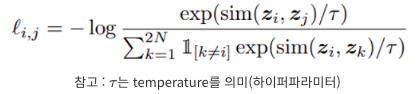

In [7]:
class SimCLR_Loss(nn.Module):
    '''
    SimCLR 논문에서는 N개의 이미지로 구서된 배치에서 각 이미지에 augmentation된 N개의 이미지를 합쳐 총 2N개의 이미지를 최종 배치로 구성
    이후 해당 이미지는 augmentation된 이미지 pair만 positive data(분자 부분)으로 간주하고
    해당 이미지 - 나머지 이미지의 2N-2개 pair들은 negative data(분모 부분)으로 간주하여 아래의 식처럼 contrastive loss를 계산
    GPU의 연산 효율성을 위해 배치 내 연산을 행렬 형태로 ㅎ나번에 수행되게 만드는 것이 중요
    tau = temperature
    '''
    def __init__(self,batch_size,temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction = "sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)
    # loss 분모 부분의 negative sample 간의 내적 합만을 가져오기 위한 마스킹 행렬
    def mask_correlated_samples(self, batch_size):
        N = 2*batch_size
        mask = torch.ones((N,N),dtype = bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i,batch_size +i] = 0
            mask[batch_size +i,i] = 0
        return mask
    def forward(self,z_i,z_j):
        N = 2*self.batch_size
        z = torch.cat((z_i,z_j),dim = 0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        # loss 분자 부분의 원본 - augmentation 이미지 간의 내적 합을 가져오기 위한 부분
        sim_i_j = torch.diag(sim,self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        positive_samples = torch.cat((sim_i_j, sim_j_i),dim=0).reshape(N,1)
        negative_samples = sim[self.mask].reshape(N,-1)

        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()

        logits = torch.cat((positive_samples, negative_samples),dim = 1)
        loss = self.criterion(logits,labels)
        loss /=N
        return loss

In [16]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

X_train_aug = cutout_and_rotate(X_train) # 각 X_train 데이터에 대하여 augmentation
X_train_aug = X_train_aug.to(device) # 학습을 위하여 GPU에 선언

dataset = TensorDataset(X_train,X_train_aug)
batch_size = 32

dataloader = DataLoader(
    dataset,
    batch_size = batch_size
)

model = CNN()
loss_func = SimCLR_Loss(batch_size, temperature = 0.5)

# train 코드 예시
epochs = 10
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)

for i in range(1, epochs +1):
    total_loss = 0
    for data in tqdm(dataloader):
        origin_vec = model(data[0])
        aug_vec = model(data[1])
        
        loss = loss_func(origin_vec, aug_vec)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {i}, Avg Loss : {total_loss/len(dataloader)}')

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1, Avg Loss : 3.022806482696533


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2, Avg Loss : 2.8036168469746907


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3, Avg Loss : 2.751772097905477


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4, Avg Loss : 2.717515159098307


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5, Avg Loss : 2.7030333647410076


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6, Avg Loss : 2.6832421831766764


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7, Avg Loss : 2.6746383385976156


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8, Avg Loss : 2.6588897300720213


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9, Avg Loss : 2.6513317929585773


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10, Avg Loss : 2.6526594529469807


In [17]:
# 다운 스트림 모델 선언
'''
클래스 개수 만큼의 차원으로 projection을 진행하는 mlp layer를 장착
'''
class CNN_classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.CNN = model # contrastive learning으로 학습해둔 모델을 불러오기
        self.mlp = nn.Linear(100,10) # class 차원 개수로 projection
    def forward(self,x):
        x = self.CNN(x) # (batch, 100)으로 변환
        x = self.mlp(x) # (batch, 10)으로 변환
        return x

In [18]:
class_dataset = TensorDataset(X_train, y_train)
batch_size = 32

class_dataloader = DataLoader(
    class_dataset,
    batch_size = batch_size
)

In [20]:
classifier = CNN_classifier(model).to(device) # 모델 선언, CPU 활용 지정
classifier_loss = nn.CrossEntropyLoss() # 분류를 위한 loss 함수

epochs = 10
classifier.train()

optimizer = torch.optim.Adam(classifier.parameters(),lr=1e-4)

for i in range(1, epochs +1):
    correct = 0
    for data in tqdm(class_dataloader):
        logits = classifier(data[0])

        loss = classifier_loss(logits,data[1].long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(logits, 1) == data[1]).item() # 정확도 산출을 위해 정답 개수 누적
    print(f'Epch {i}, Train accuracy {correct * 100 / len(X_train)}')

  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 1, Train accuracy 70.41666666666667


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 2, Train accuracy 95.60833333333333


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 3, Train accuracy 97.09666666666666


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 4, Train accuracy 97.67333333333333


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 5, Train accuracy 98.04833333333333


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 6, Train accuracy 98.335


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 7, Train accuracy 98.56166666666667


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 8, Train accuracy 98.70166666666667


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 9, Train accuracy 98.825


  0%|          | 0/1875 [00:00<?, ?it/s]

Epch 10, Train accuracy 98.97666666666667


In [22]:
test_dataset = TensorDataset(X_test,y_test) # 테스트 데이터와 라벨 pair
batch_size = 32
test_dataloader = DataLoader(
    test_dataset,
    batch_size = batch_size
)
classifier.eval() # 테스트 모드로 전환

correct = 0
for data in tqdm(test_dataloader):

    logits = classifier(data[0])
    correct += torch.sum(torch.argmax(logits,1) == data[1]).item() # 정확도 산출을 위하여 정답 개수 누적
print(f'Test Accuracy {correct * 100 / len(X_test)}')

  0%|          | 0/313 [00:00<?, ?it/s]

Test Accuracy 98.54
